# **Task Steps:**
### **1. Load an open source language model of your choice**:
 for starters we will works with Gpt-2 as it's good for the task at hand in terms of capbility and that it requires moderate resources, it will serve us well with benchmarks and optimizations. we will use the hugging face transformers library to load the model.

In [1]:
# Install necessary libraries
!pip install transformers
!pip install datasets

In [262]:
# imports and global variables
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
import os, torch, time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
num_samples = 100  # Adjust sample size as needed

Using device: cuda
PyTorch version: 2.4.0


In [325]:
# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side='left'
model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [265]:
## Test the model with a sample input

# input_text = "The quick brown fox jumps over the lazy dog."
input_text = "The quick brown fox jumps over the lazy dog. Suddenly, the dog barked loudly, startling the fox. In the nearby forest, a mysterious figure watched the scene unfold."

tokenizer.pad_token = tokenizer.eos_token
input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids.to(DEVICE)

# Generate text with attention mask
attention_mask = input_ids != tokenizer.pad_token_id  # Create attention mask
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=100,
    do_sample=True,
    temperature=0.7,  # Add randomness
    top_k=50,         # Sample from the top 50 tokens
    top_p=0.9,         # Sample from top 90% of probability mass
    num_beams=5,  # Generate 5 beams for consideration
    repetition_penalty=2.0  # Penalize repetition
)

# Decode and print the output
print("Generated text:")
print(tokenizer.decode(output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text:
The quick brown fox jumps over the lazy dog. Suddenly, the dog barked loudly, startling the fox. In the nearby forest, a mysterious figure watched the scene unfold.

"What's going on?" he asked.

"I don't know," the fox replied.

"Why do you ask?"

"Because I'm curious," the fox said.

"You want to know what's going on?"

"Yes," the fox said. "


### **2,3. Perform benchmarks on multiple datasets/ Measure and report the throughput of the model**:

we will load the required datasets first and do the benchmarks and measure the throughput of the model. for the benchmark we will estimate the preplexity of the model for the WikiText dataset, which is a common metric for language models that estimates how well it predicts a sample.

for the GSM8K we will calculate Accuracy or Exact match, these metrics are suitable for reasoning or QA tasks.


In [266]:
## Load the datasets and see a sample from each

# Load WikiText-2 dataset (small version of WikiText)
wikitext = load_dataset("wikitext", "wikitext-2-raw-v1")
print("WikiText-2 Example:", wikitext['test'][0])
print("WikiText-2 Example 2:", wikitext['test'][1])

# Load GSM8K dataset
gsm8k = load_dataset("gsm8k", "main")
print("GSM8K Example:", gsm8k['test'][0])

WikiText-2 Example: {'text': ''}
WikiText-2 Example 2: {'text': ' = Robert Boulter = \n'}
GSM8K Example: {'question': "Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?", 'answer': 'Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.\n#### 18'}


In [267]:
# Filter valid entries from the WikiText-2 test split as it seems some samples are empty
wikitext_test = [entry['text'] for entry in wikitext['test'] if entry['text'].strip()]
print(f"Number of valid entries: {len(wikitext_test)}")
print(f"First valid entry: {wikitext_test[0]}")


Number of valid entries: 2891
First valid entry:  = Robert Boulter = 



In [278]:
# Perplexity for WikiText:
def calculate_perplexity(model, tokenizer, text,device=DEVICE):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    if device==DEVICE:
        inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss    
    perplexity = torch.exp(loss)
    return perplexity.item()

In [279]:
# Use a valid sample from the filtered WikiText-2 test set and calculate perplexity for it
if wikitext_test:
    test_text = wikitext_test[0]  # Use the first valid entry
    perplexity = calculate_perplexity(model, tokenizer, test_text)
    print(f"Perplexity on sample: {perplexity}")
else:
    print("No valid entries in WikiText-2 test split.")


Perplexity on sample: 889.2794189453125


In [280]:
# calculate average perplixty for 100 samples from WikiText-2:
def average_perplexity(model, tokenizer, dataset, num_samples=10,device=DEVICE):
    total_perplexity = 0
    valid_samples = dataset[:num_samples]
    for text in valid_samples:
        perplexity = calculate_perplexity(model, tokenizer, text,device=device)
        total_perplexity += perplexity
    return total_perplexity / len(valid_samples)

In [305]:
avg_perplexity = average_perplexity(model, tokenizer, wikitext_test, num_samples=100)
tot_perplexity = average_perplexity(model, tokenizer, wikitext_test, num_samples=len(wikitext_test))
print(f"Average Perplexity on 100 samples for WikiText-2: {avg_perplexity}")
print(f"Perplexity on the entire WikiText-2 test dataset: {tot_perplexity}")

Average Perplexity on 100 samples for WikiText-2: 414.2834375
Perplexity on the entire WikiText-2 test dataset: 570.0749794621238


In [282]:
# Exact Match Accuracy for GSM8K: Evaluate if the model's output matches the correct answer:
def evaluate_gsm8k(model, tokenizer, dataset, num_samples=50,device=DEVICE):
    correct = 0
    total = min(len(dataset), num_samples)
    #for example in dataset[:num_samples]:
        #question = example['question']
    for i in range(total):
        # Access individual samples using indexing
        example = dataset[i]
        question = example['question']
        # correct_answer = example['answer']
        correct_answer = example['answer'].split("\n#### ")[-1].strip()  # Extract final numeric answer

        # Generate the model's answer
        inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True)
        if device==DEVICE:
            inputs = inputs.to(device)
        inputs["attention_mask"] = inputs["attention_mask"]
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=inputs["input_ids"].shape[1] + 50,  # Allow some room for generated text
            pad_token_id=tokenizer.eos_token_id
        )


        generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if correct_answer in generated_answer:  # Check if the correct answer appears
            correct += 1
    return correct / total

accuracy = evaluate_gsm8k(model, tokenizer, gsm8k['test'],num_samples=100)  # Test on first 100 examples
print(f"Accuracy on GSM8K (first 100 samples): {accuracy * 100:.2f}%")


Accuracy on GSM8K (first 100 samples): 12.00%


In [283]:
# Ensure pad_token_id is set to eos_token_id if it's None
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id  # Set pad token to eos token if none exists

def measure_throughput_on_dataset(model, tokenizer, dataset, dataset_name, num_samples=100, batch_size=16, max_length=512,device=DEVICE):
    total_tokens = 0
    samples_processed = 0
    start_time = time.time()

    # Adjusted for dataset format (whether it's a dictionary or list)
    for i in range(0, num_samples, batch_size):
        # Get the current batch
        batch = dataset[i:i + batch_size]  # This assumes 'dataset' is a list of samples

        if dataset_name == "WikiText-2":
            # For WikiText-2, extract 'text' from each example (just raw text)
            inputs = tokenizer(
                batch[:num_samples],  # Just a list of text samples
                return_tensors="pt", padding=True, truncation=True, max_length=max_length,
                return_attention_mask=True  # Ensure attention mask is returned
            )
            if device==DEVICE:
                inputs = inputs.to(device) 

        elif dataset_name == "GSM8K":
            # For GSM8K, extract 'question' from each example
            questions = batch['question'][:num_samples]  # Extract 'question' from each sample
            inputs = tokenizer(
                questions,  # Provide the list of questions
                return_tensors="pt", padding=True, truncation=True, max_length=max_length,
                return_attention_mask=True  # Ensure attention mask is returned
            )
            if device==DEVICE:
                inputs = inputs.to(device) 

        else:
            raise ValueError("Dataset not supported!")

        # Count total tokens in the batch
        total_tokens += inputs["input_ids"].numel()
        samples_processed += len(batch)

        # Ensure the attention mask is passed when generating outputs
        with torch.no_grad():
            # Ensure correct generation, using max_new_tokens instead of max_length
            model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=50)

    end_time = time.time()
    elapsed_time = end_time - start_time
    samples_throughput = samples_processed / elapsed_time
    tokens_throughput = total_tokens / elapsed_time

    return samples_throughput, tokens_throughput, elapsed_time


In [284]:
# Measure throughput on WikiText-2

original_wikitext_samples_throughput, original_wikitext_tokens_throughput, original_wikitext_time = measure_throughput_on_dataset(
    model, tokenizer, wikitext_test, "WikiText-2", num_samples=num_samples
)
print(f"Original WikiText-2: Processed {num_samples} samples in {original_wikitext_time:.2f} seconds.")
print(f"Original WikiText-2 Throughput: {original_wikitext_samples_throughput:.2f} samples/second, {original_wikitext_tokens_throughput:.2f} tokens/second.")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original WikiText-2: Processed 100 samples in 6.56 seconds.
Original WikiText-2 Throughput: 17.07 samples/second, 4235.22 tokens/second.


In [285]:
# Measure throughput on GSM8K

original_gsm8k_samples_throughput, original_gsm8k_tokens_throughput, original_gsm8k_time = measure_throughput_on_dataset(
    model, tokenizer, gsm8k["test"], "GSM8K", num_samples=num_samples
)
print(f"Original GSM8K: Processed {num_samples} samples in {original_gsm8k_time:.2f} seconds.")
print(f"Original GSM8K Throughput: {original_gsm8k_samples_throughput:.2f} samples/second, {original_gsm8k_tokens_throughput:.2f} tokens/second.")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original GSM8K: Processed 100 samples in 4.31 seconds.
Original GSM8K Throughput: 3.25 samples/second, 2626.25 tokens/second.


**Observations on evaluation:**
- Perplexity is used to estimate how well the model is able to predict a sequence of words or tokens, the lower the score the better the model performs, meaning the model is more confident in its predictions and assigns higher probabilities to the actual sequence.
- Accuracy on exact match is the proportion of problems the model solves correctly, if the model score low accuracy it indicates the model struggles to understand or compute the required answers.
- for throughput we used two scores : tokens per second and samples per second:
    - Tokens per second is more granular and reflects how quickly the model processes text at the token level, including cases with varying input/output lengths.
    - Samples per second is broader, focusing on how many full inputs the model processes, regardless of their token counts.

### **4,5,6. Perform optimizations on the model that would increase its throughput/Repeat Benchmarks/Measure new throughput:**
we will optimize the model to increase it's efficency whether in terms of speed or accuracy, there are Techniques to consider so we can optimize the model with such as:

- Quantization: Convert the model to use INT8 or FP16 weights for faster computation.
- Pruning: Reduce the number of parameters by removing less critical weights.
- Batching: Evaluate performance gains by processing multiple inputs simultaneously.
- Compilation: Use tools like ONNX Runtime or Hugging Face Accelerate.

we will focus on quantization in our optimization work as it yeilds best improvments in performance and compare after.

for starters we will do INT8 dynamic-quantization and see the results, this will be done on the cpu as this type (dynamic quantization) is specifically designed for inference on CPUs. It dynamically adjusts weights during runtime, which aligns well with CPU execution models. GPUs are typically optimized for FP32 and FP16 operations. Support for INT8 operations is less mature and often depends on specific frameworks or hardware (e.g., NVIDIA TensorRT or custom kernels).

In [295]:
# Apply dynamic quantization
model_cpy = AutoModelForCausalLM.from_pretrained(model_name)
quantized_model = torch.quantization.quantize_dynamic(
    model_cpy,
    {torch.nn.Linear},  # Quantize Linear layers
    dtype=torch.qint8  # Use INT8 for weights
)
quantized_model.cpu()
torch.backends.quantized.engine = "fbgemm"  # Use default CPU quantization engine

# Save the quantized model (optional)
quantized_model_path = "quantized_model.pth"
torch.save(quantized_model.state_dict(), quantized_model_path)

print("Quantization complete. Quantized model saved.")

Quantization complete. Quantized model saved.


In [299]:
# Calculate average perplexity for WikiText-2 using the quantized model
orig_avg_perplexity = average_perplexity(model_cpy, tokenizer, wikitext_test, num_samples=100,device="cpu")
print(f"Original Model Perplexity on WikiText-2: {orig_avg_perplexity}")

quantized_avg_perplexity = average_perplexity(quantized_model, tokenizer, wikitext_test, num_samples=100,device="cpu")
print(f"Quantized Model Perplexity on WikiText-2: {quantized_avg_perplexity}")

Original Model Perplexity on WikiText-2: 415.48009170532225
Quantized Model Perplexity on WikiText-2: 7063.587919921875


In [311]:
# Measure throughput on WikiText-2 on cpu
cpu_wikitext_samples_throughput, cpu_wikitext_tokens_throughput, cpu_wikitext_time = measure_throughput_on_dataset(
    model_cpy, tokenizer, wikitext_test, "WikiText-2", num_samples=num_samples,device="cpu"
)



# Measure throughput on GSM8K on cpu

cpu_gsm8k_samples_throughput, cpu_gsm8k_tokens_throughput, cpu_gsm8k_time = measure_throughput_on_dataset(
    model_cpy, tokenizer, gsm8k["test"], "GSM8K", num_samples=num_samples,device="cpu"
)


# Step 2: Measure throughput on WikiText-2 for quantized model
quantized_wikitext_samples_throughput, quantized_wikitext_tokens_throughput, quantized_wikitext_time = measure_throughput_on_dataset(
    quantized_model, tokenizer, wikitext_test, "WikiText-2", num_samples=num_samples,device="cpu"
)




# Step 3: Measure throughput on GSM8K for quantized model
quantized_gsm8k_samples_throughput, quantized_gsm8k_tokens_throughput, quantized_gsm8k_time  = measure_throughput_on_dataset(
    quantized_model, tokenizer, gsm8k["test"], "GSM8K", num_samples=num_samples,device="cpu"
)
print("Throughput comparison for INT8 Quantized Model on CPU:")
print(f"Original WikiText-2: Processed {num_samples} samples in {cpu_wikitext_time:.2f} seconds.")
print(f"Original WikiText-2 Throughput: {cpu_wikitext_samples_throughput:.2f} samples/second, {cpu_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"Original GSM8K: Processed {num_samples} samples in {cpu_gsm8k_time:.2f} seconds.")
print(f"Original GSM8K Throughput: {cpu_gsm8k_samples_throughput:.2f} samples/second, {cpu_gsm8k_tokens_throughput:.2f} tokens/second.\n")

print(f"INT8 WikiText-2: Processed {num_samples} samples in {quantized_wikitext_time:.2f} seconds.")
print(f"INT8 WikiText-2 Throughput: {quantized_wikitext_samples_throughput:.2f} samples/second, {quantized_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"INT8 GSM8K: Processed {num_samples} samples in {quantized_gsm8k_time:.2f} seconds.")
print(f"INT8 GSM8K Throughput: {quantized_gsm8k_samples_throughput:.2f} samples/second, {quantized_gsm8k_tokens_throughput:.2f} tokens/second.\n")

# Check if model is saved successfully
if os.path.exists(quantized_model_path):
    print("Quantized model is successfully saved and ready for reuse!")
else:
    print("Failed to save the quantized model.")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Throughput comparison for INT8 Quantized Model on CPU:
Original WikiText-2: Processed 100 samples in 111.97 seconds.
Original WikiText-2 Throughput: 1.00 samples/second, 248.21 tokens/second.

Original GSM8K: Processed 100 samples in 58.48 seconds.
Original GSM8K Throughput: 0.24 samples/second, 193.72 tokens/second.

INT8 WikiText-2: Processed 100 samples in 108.30 seconds.
INT8 WikiText-2 Throughput: 1.03 samples/second, 256.62 tokens/second.

INT8 GSM8K: Processed 100 samples in 48.62 seconds.
INT8 GSM8K Throughput: 0.29 samples/second, 232.97 tokens/second.

Quantized model is successfully saved and ready for reuse!


**Observations:**
- the throughput increased after quantization as the model is more light-weight hence the increase in throughput.
- however the perplexity decreased dramtically, this is due to multiple reasons:
    - Reduced Precision Representation: INT8 quantization reduces the precision of weights and activations from 32-bit or 16-bit floating-point numbers to 8-bit integers, While this drastically reduces the memory footprint and computation costs, it also introduces quantization noise, leading to a loss of precision in model calculations.
    - Sensitivity of Language Models: Language models like GPT-2 are highly sensitive to small changes in weights and activations.
    - INT8 quantization prioritizes throughput (inference speed) and resource efficiency over accuracy.

looking closely on the throughput increase isn't that high compared to the perplexity(accuracy) decrease, so this quantization model is not optimal.

Next, we will try fp16(half-precision) quantization.

In [312]:
# Convert the model to half-precision
model_fp16 = model.half()

# Save the half-precision model for future use
fp16_model_path = "model_fp16.pth"
torch.save(model_fp16.state_dict(), fp16_model_path)

print("Model converted to half-precision and saved.")

Model converted to half-precision and saved.


In [308]:
# Calculate average perplexity for WikiText-2 using the quantized model
origg_avg_perplexity = average_perplexity(model, tokenizer, wikitext_test, num_samples=100)
fp16_avg_perplexity = average_perplexity(model_fp16, tokenizer, wikitext_test, num_samples=100)
# Output the results
print(f"Original Model Perplexity on WikiText-2: {origg_avg_perplexity}")
print(f"fp16 Model Perplexity on WikiText-2: {fp16_avg_perplexity}")

Original Model Perplexity on WikiText-2: 414.2834375
fp16 Model Perplexity on WikiText-2: 414.2834375


In [313]:
# Step 2: Measure throughput on WikiText-2
fp16_wikitext_samples_throughput, fp16_wikitext_tokens_throughput, fp16_wikitext_time = measure_throughput_on_dataset(
    model_fp16, tokenizer, wikitext_test, "WikiText-2", num_samples=num_samples
)

# Step 3: Measure throughput on GSM8K
fp16_gsm8k_samples_throughput, fp16_gsm8k_tokens_throughput, fp16_gsm8k_time  = measure_throughput_on_dataset(
    model_fp16, tokenizer, gsm8k["test"], "GSM8K", num_samples=num_samples
)

# Step 4: Print the throughput results for both datasets
print("Throughput Results for fp16 Model:")

print(f"Original WikiText-2: Processed {num_samples} samples in {original_wikitext_time:.2f} seconds.")
print(f"Original WikiText-2 Throughput: {original_wikitext_samples_throughput:.2f} samples/second, {original_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"Original GSM8K: Processed {num_samples} samples in {original_gsm8k_time:.2f} seconds.")
print(f"Original GSM8K Throughput: {original_gsm8k_samples_throughput:.2f} samples/second, {original_gsm8k_tokens_throughput:.2f} tokens/second.\n")


print(f"GSM8K: Processed {num_samples} samples in {fp16_wikitext_time:.2f} seconds.")
print(f"WikiText-2 Throughput: {fp16_wikitext_samples_throughput:.2f} samples/second, {fp16_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"GSM8K: Processed {num_samples} samples in {fp16_gsm8k_time:.2f} seconds.")
print(f"GSM8K Throughput: {fp16_gsm8k_samples_throughput:.2f} samples/second, {fp16_gsm8k_tokens_throughput:.2f} tokens/second.")

# Check if model is saved successfully
if os.path.exists(fp16_model_path):
    print("Quantized model is successfully saved and ready for reuse!")
else:
    print("Failed to save the quantized model.")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Throughput Results for fp16 Model:
Original WikiText-2: Processed 100 samples in 6.56 seconds.
Original WikiText-2 Throughput: 17.07 samples/second, 4235.22 tokens/second.

Original GSM8K: Processed 100 samples in 4.31 seconds.
Original GSM8K Throughput: 3.25 samples/second, 2626.25 tokens/second.

GSM8K: Processed 100 samples in 4.00 seconds.
WikiText-2 Throughput: 27.99 samples/second, 6944.57 tokens/second.

GSM8K: Processed 100 samples in 3.68 seconds.
GSM8K Throughput: 3.81 samples/second, 3081.19 tokens/second.
Quantized model is successfully saved and ready for reuse!


**Observations:**
after using half-precision quantization we notice that Perplexity score is typically the same as that of the original model, while the throughput increased significantlly, so this optimization technique proved well as an optimization for the model.


### **7,8. Fine-tune the model / Repeat the benchmarks in step 2 on the same datasets:**
We will fine tune the model on the datasets and we should notice a siginficant increase in accuracy as our model 'GPT2' isn't trained on neither of them.
due to limitations in resources in our working environment, we will only finetune the model on the first dataset "Wikitext", and we can do the same process with the "gsm8k" dataset.

In [356]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
from transformers.trainer_utils import get_last_checkpoint

def fine_tune_model(model, tokenizer, model_name, output_dir="./results", num_train_epochs=3, batch_size=4, save_steps=500):
    """
    Fine-tune the pre-trained model on the WikiText-2 dataset.
    
    Args:
    - model: Pre-loaded model to fine-tune.
    - tokenizer: Pre-loaded tokenizer for tokenizing the dataset.
    - model_name: Name of the pre-trained model (e.g., 'gpt2').
    - output_dir: Directory to save results and checkpoints.
    - num_train_epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - save_steps: Number of steps between saving the model.
    """
    # Step 1: Load WikiText-2 Dataset and Filter Out Empty Samples
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
    dataset = dataset.filter(lambda x: len(x['text'].strip()) > 0)  # Remove empty samples

    # Step 2: Tokenize the Dataset
    def tokenize_function(examples):
        return tokenizer(examples["text"], return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

    # Step 3: Prepare Data Collator and Training Arguments
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)  # Language Modeling for GPT-2 (causal LM)
    
    training_args = TrainingArguments(
        output_dir=output_dir,            # Output directory
        overwrite_output_dir=True,        # Overwrite if output_dir exists
        num_train_epochs=num_train_epochs, # Number of epochs
        per_device_train_batch_size=batch_size,  # Batch size per device (adjust as needed)
        save_steps=save_steps,                  # Save model every 'save_steps' steps
        fp16=True,                            # Enables mixed precision training
        logging_dir="./logs",                # Directory for logs
        logging_steps=10,                    # Log every 10 steps
        save_total_limit=2,                  # Limit the number of saved models
        eval_strategy="steps",         # Evaluate every 'eval_steps' steps
        eval_steps=500,
        save_strategy="steps",               # Save model every 'save_steps' steps
        load_best_model_at_end=True,         # Load the best model after training
        metric_for_best_model="loss",        # Metric for selecting the best model
        greater_is_better=False, 
        report_to="none",
        remove_unused_columns=False          # Ensure unused columns are not included
    )

    last_checkpoint = None
    if os.path.isdir(output_dir) and os.listdir(output_dir):
        last_checkpoint = get_last_checkpoint(output_dir)
        if last_checkpoint:
            print(f"Resuming from checkpoint: {last_checkpoint}")
    
    # Step 4: Initialize the Trainer
    trainer = Trainer(
        model=model,                     # Use the pre-loaded model
        args=training_args,              # Training arguments
        data_collator=data_collator,     # Data collator
        train_dataset=tokenized_datasets["train"],  # Use the tokenized train dataset
        eval_dataset=tokenized_datasets["validation"]  # Use the tokenized validation dataset
    )

    # Step 5: Train the Model
    trainer.train(resume_from_checkpoint=last_checkpoint)

    # Step 6: Save the Fine-tuned Model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Fine-tuning complete. Model saved at {output_dir}")

In [357]:
# Example usage:
tuned_model = model
tuned_tokenizer = tokenizer
fine_tune_model(tuned_model.to(DEVICE), tuned_tokenizer, model_name="gpt2", output_dir="./finetuned_model", num_train_epochs=1, batch_size=4, save_steps=500)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Resuming from checkpoint: ./finetuned_model/checkpoint-2500


/opt/conda/lib/python3.10/site-packages/transformers/trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Fine-tuning complete. Model saved at ./finetuned_model


In [359]:
# Calculate average perplexity for WikiText-2 using the funetuned model
tuned_model.to(DEVICE)
tuned_model_avg_perplexity = average_perplexity(tuned_model, tuned_tokenizer, wikitext_test, num_samples=100)
# Output the results
print(f"Original Model Perplexity on WikiText-2: {origg_avg_perplexity}")
print(f"finetuned Model Perplexity on WikiText-2: {tuned_model_avg_perplexity}")

Original Model Perplexity on WikiText-2: 414.2834375
finetuned Model Perplexity on WikiText-2: 53.79378763437271


In [360]:
# Step 2: Measure throughput on WikiText-2
tuned_wikitext_samples_throughput, tuned_wikitext_tokens_throughput, tuned_wikitext_time = measure_throughput_on_dataset(
    tuned_model, tuned_tokenizer, wikitext_test, "WikiText-2", num_samples=num_samples
)

# Step 3: Measure throughput on GSM8K
tuned_gsm8k_samples_throughput, tuned_gsm8k_tokens_throughput, tuned_gsm8k_time  = measure_throughput_on_dataset(
    tuned_model, tuned_tokenizer, gsm8k["test"], "GSM8K", num_samples=num_samples
)

# Step 4: Print the throughput results for both datasets
print("Throughput Results for fp16 Model:")

print(f"Original WikiText-2: Processed {num_samples} samples in {original_wikitext_time:.2f} seconds.")
print(f"Original WikiText-2 Throughput: {original_wikitext_samples_throughput:.2f} samples/second, {original_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"Original GSM8K: Processed {num_samples} samples in {original_gsm8k_time:.2f} seconds.")
print(f"Original GSM8K Throughput: {original_gsm8k_samples_throughput:.2f} samples/second, {original_gsm8k_tokens_throughput:.2f} tokens/second.\n")


print(f"GSM8K: Processed {num_samples} samples in {tuned_wikitext_time:.2f} seconds.")
print(f"WikiText-2 Throughput: {tuned_wikitext_samples_throughput:.2f} samples/second, {tuned_wikitext_tokens_throughput:.2f} tokens/second.\n")

print(f"GSM8K: Processed {num_samples} samples in {fp16_gsm8k_time:.2f} seconds.")
print(f"GSM8K Throughput: {tuned_gsm8k_samples_throughput:.2f} samples/second, {tuned_gsm8k_tokens_throughput:.2f} tokens/second.")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Throughput Results for fp16 Model:
Original WikiText-2: Processed 100 samples in 6.56 seconds.
Original WikiText-2 Throughput: 17.07 samples/second, 4235.22 tokens/second.

Original GSM8K: Processed 100 samples in 4.31 seconds.
Original GSM8K Throughput: 3.25 samples/second, 2626.25 tokens/second.

GSM8K: Processed 100 samples in 6.71 seconds.
WikiText-2 Throughput: 16.70 samples/second, 4143.24 tokens/second.

GSM8K: Processed 100 samples in 3.68 seconds.
GSM8K Throughput: 3.10 samples/second, 2510.84 tokens/second.


**Observations:** 
- We notice that model's Perplexity increased drastically, proving that the model got trained well on the dataset and that the fine-tuning process is successful.
- the throughput is the same as the original model, proving that the fine-tuning didn't affect the model's speed, only its accuracy.

### **9. Plot the difference in quality and throughput between the 3 versions of the model:**
We will plot the 3 versions of the model's Perplexity and throughput and compare the differences.


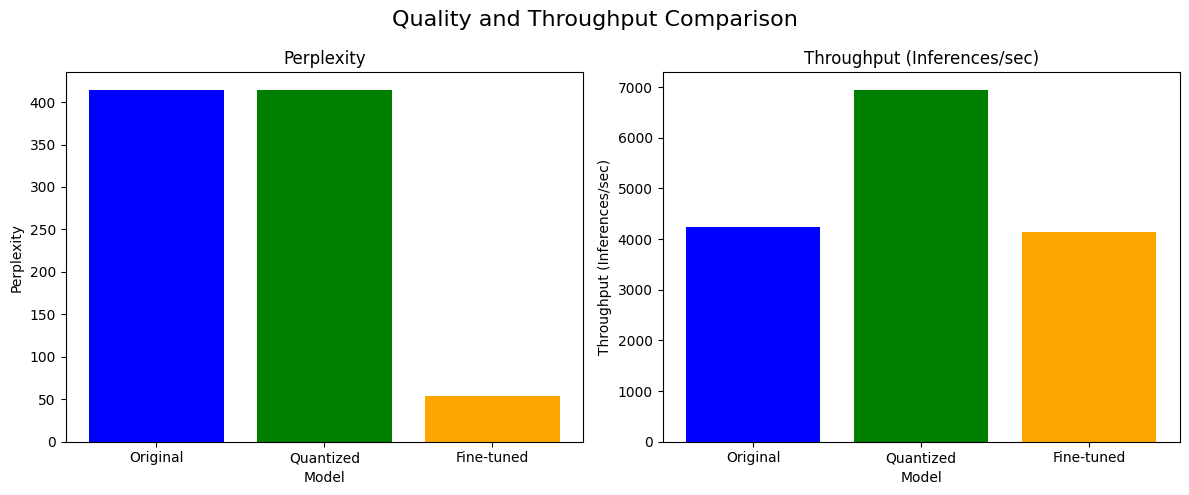

In [361]:
import matplotlib.pyplot as plt

def plot_comparison(models, metrics, labels, metric_names, title="Model Comparison"):
    """
    Plot the comparison of models based on given metrics.
    """
    x = range(len(models))
    fig, axes = plt.subplots(1, len(metrics), figsize=(12, 5))
    fig.suptitle(title, fontsize=16)
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        axes[i].bar(x, metric, color=['blue', 'green', 'orange'], tick_label=labels)
        axes[i].set_title(name)
        axes[i].set_ylabel(name)
        axes[i].set_xlabel("Model")
    plt.tight_layout()
    plt.show()

# Example saved values for Perplexity and Throughput
model_labels = ["Original", "Quantized", "Fine-tuned"]

# Replace these with your saved values
perplexities = [origg_avg_perplexity, fp16_avg_perplexity, tuned_model_avg_perplexity]  # Example values
throughputs = [original_wikitext_tokens_throughput, fp16_wikitext_tokens_throughput, tuned_wikitext_tokens_throughput]  # Example values

# Plot Results
plot_comparison(
    models=model_labels,
    metrics=[perplexities, throughputs],
    labels=model_labels,
    metric_names=["Perplexity", "Throughput (Inferences/sec)"],
    title="Quality and Throughput Comparison"
)


**Observations:**
- Perplexity(Accuracy): the original model and the quantized one(fp16) both have the same value, while the finetuned one has much lower score for Perplexity(better performance), as the quantization improves the speed but maintains the accuracy, while the fine-tuning improves the accuracy and maintains the speed.

- Throughput: the original model and the fine-tuned one have the same throughput and the quantized one has a much higher throughput, proving the increase gained from the quantization process.